In [1]:
import warnings
warnings.simplefilter("ignore")

# 1. Install and Import Dependencies

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

# 2. Load and Filter Data

In [26]:
df = pd.read_csv("dataset.csv")

In [27]:
df.head()

,Date,Store,Product,Value
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000


- We'll create 1 slice of our data. 
- Basically filter down 1 store and 1 product. (LA and Tesla model X)
- This is how prophet expects us to pass the data through.
- Hence, we spearate our Time series model for each store and each product.

**Note:**
- Prophet expects the data to have date column first then the target column y.


In [28]:
df["Store"].unique()

array(['LOS_ANGELES', 'SAN_FRANCISCO'], dtype=object)

In [29]:
df["Product"].unique()

array(['TESLA_MODEL_X', 'TESLA_MODEL_S'], dtype=object)

Since we have LA, SF with Tesla X and Tesla S, we'll have 4 different models.

Let's filter on LA and Tesla model X

In [30]:
df_la_model_x = df[(df["Store"] == "LOS_ANGELES") & (df["Product"] == "TESLA_MODEL_X")]

In [31]:
df_la_model_x

,Date,Store,Product,Value
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000000
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531000
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000000
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000000
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000000
...,...,...,...,...
1075,20201212,LOS_ANGELES,TESLA_MODEL_X,3167.594500
1076,20201213,LOS_ANGELES,TESLA_MODEL_X,3167.594500
1077,20201214,LOS_ANGELES,TESLA_MODEL_X,3383.354511
1078,20201215,LOS_ANGELES,TESLA_MODEL_X,2714.591329


# 3. Preprocess and Create Partitions

- For Time Series model, we usually split on a dates
- A set of dates will go into Training dataset(historic dates) and remaining will go into Testing dataset(future dates).

## Create Dates

In [32]:
df_la_model_x.dtypes

Date         int64
Store       object
Product     object
Value      float64
dtype: object

- Change datatype of Date to datetime object using pd.to_datetime() and store it in a new column called 'ds'

In [33]:
df_la_model_x["ds"] = pd.to_datetime(df_la_model_x["Date"], format="%Y%m%d")

In [34]:
df_la_model_x.dtypes

Date                int64
Store              object
Product            object
Value             float64
ds         datetime64[ns]
dtype: object

In [35]:
df_la_model_x.head(25)

,Date,Store,Product,Value,ds
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.0000,2018-01-01
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.5310,2018-01-02
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.0000,2018-01-03
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.0000,2018-01-04
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.0000,2018-01-05
5,20180106,LOS_ANGELES,TESLA_MODEL_X,2527.0000,2018-01-06
6,20180107,LOS_ANGELES,TESLA_MODEL_X,2527.0000,2018-01-07
7,20180108,LOS_ANGELES,TESLA_MODEL_X,2793.0000,2018-01-08
8,20180109,LOS_ANGELES,TESLA_MODEL_X,2793.0000,2018-01-09
9,20180110,LOS_ANGELES,TESLA_MODEL_X,2793.0000,2018-01-10


- Create day, month, year columns from 'ds' column

In [36]:
# test columns, not needed

df_la_model_x["day"] = df_la_model_x["ds"].dt.day
df_la_model_x["month"] = df_la_model_x["ds"].dt.month
df_la_model_x["year"] = df_la_model_x["ds"].dt.year

In [37]:
df_la_model_x.head()

,Date,Store,Product,Value,ds,day,month,year
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000,2018-01-01,1,1,2018
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531,2018-01-02,2,1,2018
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000,2018-01-03,3,1,2018
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000,2018-01-04,4,1,2018
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000,2018-01-05,5,1,2018


- Since there's only 1 store and 1 product, we cna drop them.

In [38]:
df_la_model_x =  df_la_model_x.drop(["Date", "Store", "Product", "day", "month", "year"], axis=1)

In [39]:
df_la_model_x.head()

,Value,ds
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


- Since prophet expects the date column to be named 'ds' and target column to be named 'y', we'll rename the columns.

In [40]:
df_la_model_x.columns = ["y", "ds"]

In [41]:
df_la_model_x.head()

,y,ds
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


## Visualise the Data to Determine Appropriate Partitions

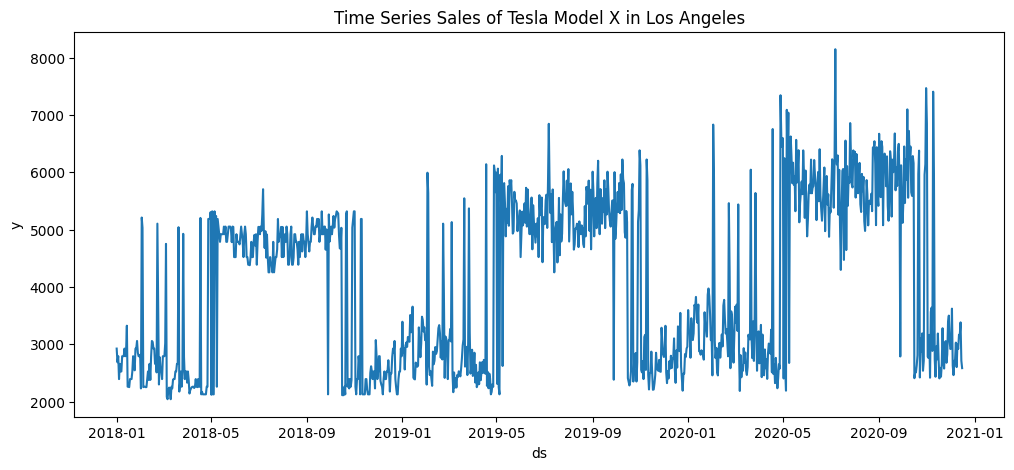

In [45]:
plt.figure(figsize = (12, 5))
sns.lineplot( x = "ds", y = "y", data = df_la_model_x).set_title("Time Series Sales of Tesla Model X in Los Angeles")
plt.show()

- has monthly seasonality
- has yearly seasonality

## Create Train and Test Splits

In [46]:
df_la_model_x["ds"].min(), df_la_model_x["ds"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-12-16 00:00:00'))

- We have data from 2018 to 2020. So we can partition the data.
- 1.5 yrs data in training and 6 months data in testing.

In [47]:
train = df_la_model_x[df_la_model_x["ds"] < "2020-06-30 00:00:00"]
test = df_la_model_x[df_la_model_x["ds"] >= "2020-06-30 00:00:00"]

In [48]:
train.head()

,y,ds
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


In [49]:
train.shape

(910, 2)

In [50]:
test.head()

,y,ds
910,5375.487600,2020-06-30
911,5302.434956,2020-07-01
912,5761.299520,2020-07-02
913,6228.017600,2020-07-03
914,6114.834600,2020-07-04


In [51]:
test.shape

(170, 2)

In [54]:
# % of test data
170/(910 + 170)

0.1574074074074074

# 4. Train Model

In [56]:
prophet_clf = Prophet()

In [57]:
prophet_clf.fit(train)

16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:38 - cmdstanpy - INFO - Chain [1] done processing


# 5. Evaluate Model

## Make Predictions on Test Set

- Metric: MAE

In [59]:
from sklearn.metrics import mean_absolute_error

In [60]:
y_pred = prophet_clf.predict(test[["ds"]]) # pass entire df not pandas series. Hence double brackets 

In [61]:
y_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-30,4355.765975,4488.203148,6491.414930,4355.765975,4355.765975,1113.302361,1113.302361,1113.302361,-7.935457,-7.935457,-7.935457,1121.237818,1121.237818,1121.237818,0.0,0.0,0.0,5469.068336
1,2020-07-01,4356.711134,4411.813345,6347.957669,4356.711134,4356.711134,1099.106972,1099.106972,1099.106972,-13.477089,-13.477089,-13.477089,1112.584061,1112.584061,1112.584061,0.0,0.0,0.0,5455.818106
2,2020-07-02,4357.656294,4477.002308,6490.296693,4357.656294,4357.656294,1121.361295,1121.361295,1121.361295,15.737098,15.737098,15.737098,1105.624197,1105.624197,1105.624197,0.0,0.0,0.0,5479.017589
3,2020-07-03,4358.601454,4386.607085,6444.383833,4358.601454,4358.601454,1061.175328,1061.175328,1061.175328,-39.351680,-39.351680,-39.351680,1100.527008,1100.527008,1100.527008,0.0,0.0,0.0,5419.776781
4,2020-07-04,4359.546613,4504.184138,6468.204220,4359.546613,4359.546613,1071.483869,1071.483869,1071.483869,-25.910925,-25.910925,-25.910925,1097.394794,1097.394794,1097.394794,0.0,0.0,0.0,5431.030482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2020-12-12,4511.717312,2031.266147,4055.608314,4511.709519,4511.725894,-1386.362843,-1386.362843,-1386.362843,-25.910925,-25.910925,-25.910925,-1360.451918,-1360.451918,-1360.451918,0.0,0.0,0.0,3125.354469
166,2020-12-13,4512.662471,2188.383410,4280.813707,4512.654630,4512.671111,-1296.773587,-1296.773587,-1296.773587,47.692912,47.692912,47.692912,-1344.466499,-1344.466499,-1344.466499,0.0,0.0,0.0,3215.888885
167,2020-12-14,4513.607631,2297.180204,4163.623741,4513.599717,4513.616328,-1306.034593,-1306.034593,-1306.034593,23.245142,23.245142,23.245142,-1329.279734,-1329.279734,-1329.279734,0.0,0.0,0.0,3207.573038
168,2020-12-15,4514.552791,2174.430252,4220.431273,4514.544780,4514.561544,-1322.927814,-1322.927814,-1322.927814,-7.935457,-7.935457,-7.935457,-1314.992356,-1314.992356,-1314.992356,0.0,0.0,0.0,3191.624977


In [62]:
mean_absolute_error(test[["y"]], y_pred[["yhat"]])

702.3627274460443

## Make New Predictions

- Make future predictions for the next 6 months (unseen dates in the future). This feature is built into prophet.

In [75]:
# to create dates in the future
future = prophet_clf.make_future_dataframe(periods = 500, freq = "D")
future.head()

,ds
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05


In [76]:
forecast = prophet_clf.predict(future)

In [77]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1405,2021-11-07,4823.619986,2996.946344,4989.790450,4823.573403,4823.664791,-790.372413,-790.372413,-790.372413,47.692912,47.692912,47.692912,-838.065325,-838.065325,-838.065325,0.0,0.0,0.0,4033.247573
1406,2021-11-08,4824.565145,2953.818641,5056.859781,4824.518381,4824.610097,-846.483081,-846.483081,-846.483081,23.245142,23.245142,23.245142,-869.728223,-869.728223,-869.728223,0.0,0.0,0.0,3978.082064
1407,2021-11-09,4825.510305,2863.736118,4870.358177,4825.463401,4825.555370,-910.982580,-910.982580,-910.982580,-7.935457,-7.935457,-7.935457,-903.047122,-903.047122,-903.047122,0.0,0.0,0.0,3914.527725
1408,2021-11-10,4826.455464,2837.832151,4897.923760,4826.408420,4826.500643,-951.496736,-951.496736,-951.496736,-13.477089,-13.477089,-13.477089,-938.019647,-938.019647,-938.019647,0.0,0.0,0.0,3874.958729
1409,2021-11-11,4827.400624,2897.613410,4906.180652,4827.353440,4827.445899,-958.820629,-958.820629,-958.820629,15.737098,15.737098,15.737098,-974.557728,-974.557728,-974.557728,0.0,0.0,0.0,3868.579995


In [78]:
future.tail()

,ds
1405,2021-11-07
1406,2021-11-08
1407,2021-11-09
1408,2021-11-10
1409,2021-11-11


In [79]:
test.tail()

,y,ds
1075,3167.594500,2020-12-12
1076,3167.594500,2020-12-13
1077,3383.354511,2020-12-14
1078,2714.591329,2020-12-15
1079,2585.035107,2020-12-16


- Future has dates in the future compared to test data.

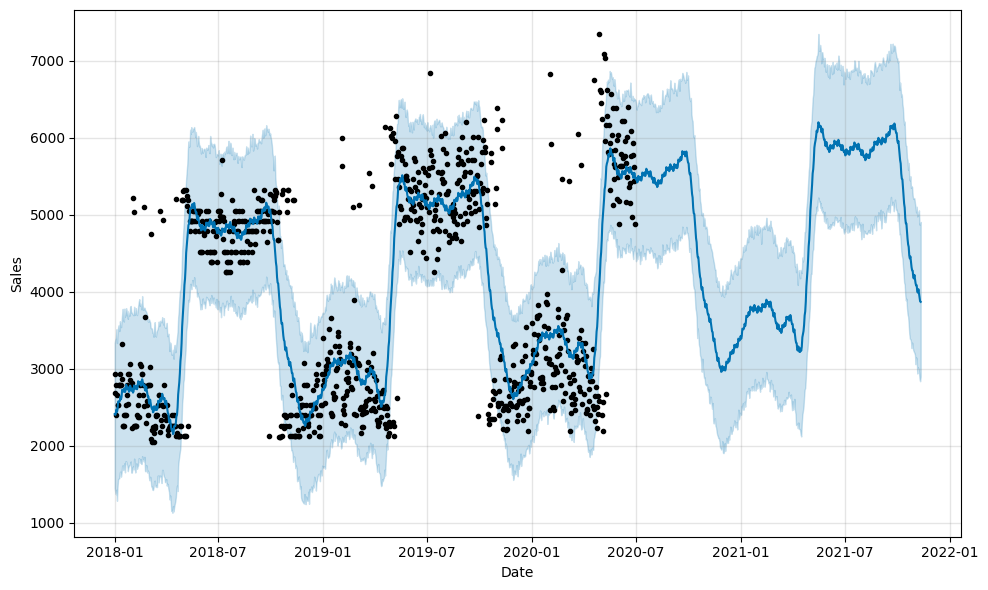

In [81]:
forecast_plot = prophet_clf.plot(forecast, xlabel = "Date", ylabel = "Sales")

- dark blue line : y-pred values (point estimate)

- confidence interval for the sales predictions; Range of values that the sales will fall in.
  - light upper blue shade = y_pred_upper values 
  - light lower blue shade = y_pred_lower values

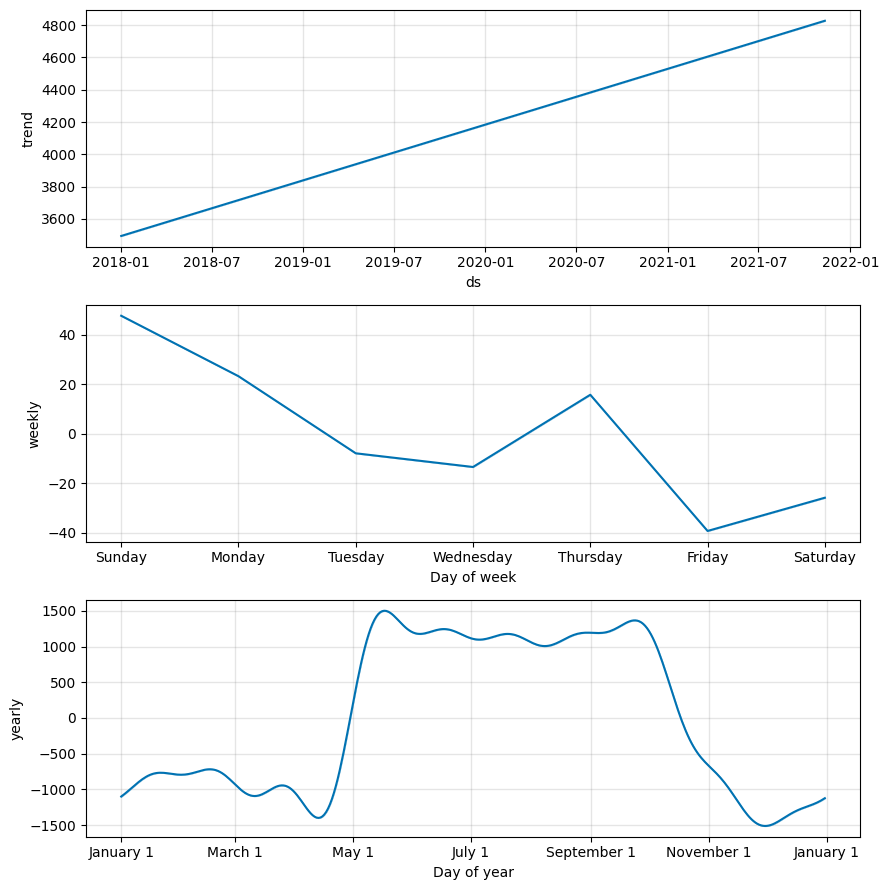

In [82]:
components_plot = prophet_clf.plot_components(forecast)

- Above graph shows seasonality and trend. for yearly, weekly and montly

# 6. Save Model

In [83]:
import json
from prophet.serialize import model_to_json, model_from_json #model_to_json: save our model; model_from_json: load our model

In [84]:
with open("serialized_model.json", "w") as fout:
    json.dump(model_to_json(prophet_clf), fout) # save our model

In [85]:
# reload the model
with open("serialized_model.json", "r") as fin:
    m = model_from_json(json.load(fin))

test the reloaded model

In [86]:
future = m.make_future_dataframe(periods = 100, freq = "D")
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1005,2020-10-03,4445.556138,4423.867862,6551.095577,4445.552367,4445.560230,1079.449897,1079.449897,1079.449897,-25.910925,-25.910925,-25.910925,1105.360822,1105.360822,1105.360822,0.0,0.0,0.0,5525.006035
1006,2020-10-04,4446.501298,4499.445618,6562.666651,4446.497492,4446.505463,1093.302451,1093.302451,1093.302451,47.692912,47.692912,47.692912,1045.609539,1045.609539,1045.609539,0.0,0.0,0.0,5539.803749
1007,2020-10-05,4447.446458,4555.290290,6501.580516,4447.442613,4447.450684,1003.638485,1003.638485,1003.638485,23.245142,23.245142,23.245142,980.393343,980.393343,980.393343,0.0,0.0,0.0,5451.084943
1008,2020-10-06,4448.391617,4302.048260,6383.581874,4448.387735,4448.395897,902.287732,902.287732,902.287732,-7.935457,-7.935457,-7.935457,910.223189,910.223189,910.223189,0.0,0.0,0.0,5350.679349
1009,2020-10-07,4449.336777,4277.877523,6284.269581,4449.332856,4449.341078,822.220101,822.220101,822.220101,-13.477089,-13.477089,-13.477089,835.697190,835.697190,835.697190,0.0,0.0,0.0,5271.556878


# 7. Create models for each combo of store location and tesla model

## Process Entire Dataframe

In [87]:
# reload data
df = pd.read_csv("dataset.csv")

In [90]:
df["ds"] = pd.to_datetime(df["Date"], format="%Y%m%d")

In [91]:
df.head()

,Date,Store,Product,Value,ds
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000,2018-01-01
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531,2018-01-02
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000,2018-01-03
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000,2018-01-04
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000,2018-01-05


In [92]:
df.dtypes

Date                int64
Store              object
Product            object
Value             float64
ds         datetime64[ns]
dtype: object

## Create Model Building Function

In [94]:
# baseline function

def build_model (df, product, store):
    # filter data for store and product
    filtered_df = df[(df["Product"] == product) & (df["Store"] == store)]
    # drop columns
    filtered_df = filtered_df.drop(["Date", "Store", "Product"], axis=1)
    # rename columns
    filtered_df.columns = ["y", "ds"]
    
    # fit the prophet model on all the data
    # create model
    prophet_clf = Prophet()
    prophet_clf.fit(filtered_df)
    
    # save the model
    with open(f"serialized_model_{product}_{store}.json", "w") as fout:
        json.dump(model_to_json(prophet_clf), fout)
    
    return f"Model fitted for {product} and {store}"

In [95]:
build_model(df, "TESLA_MODEL_X", "LOS_ANGELES")

16:58:21 - cmdstanpy - INFO - Chain [1] start processing
16:58:21 - cmdstanpy - INFO - Chain [1] done processing


'Model fitted for TESLA_MODEL_X and LOS_ANGELES'

In [96]:
# reload the model
with open("serialized_model_TESLA_MODEL_X_LOS_ANGELES.json", "r") as fin:
    reloaded_model = model_from_json(json.load(fin))

In [97]:
refuture = reloaded_model.make_future_dataframe(periods = 100, freq = "D")
reforecast = reloaded_model.predict(refuture)

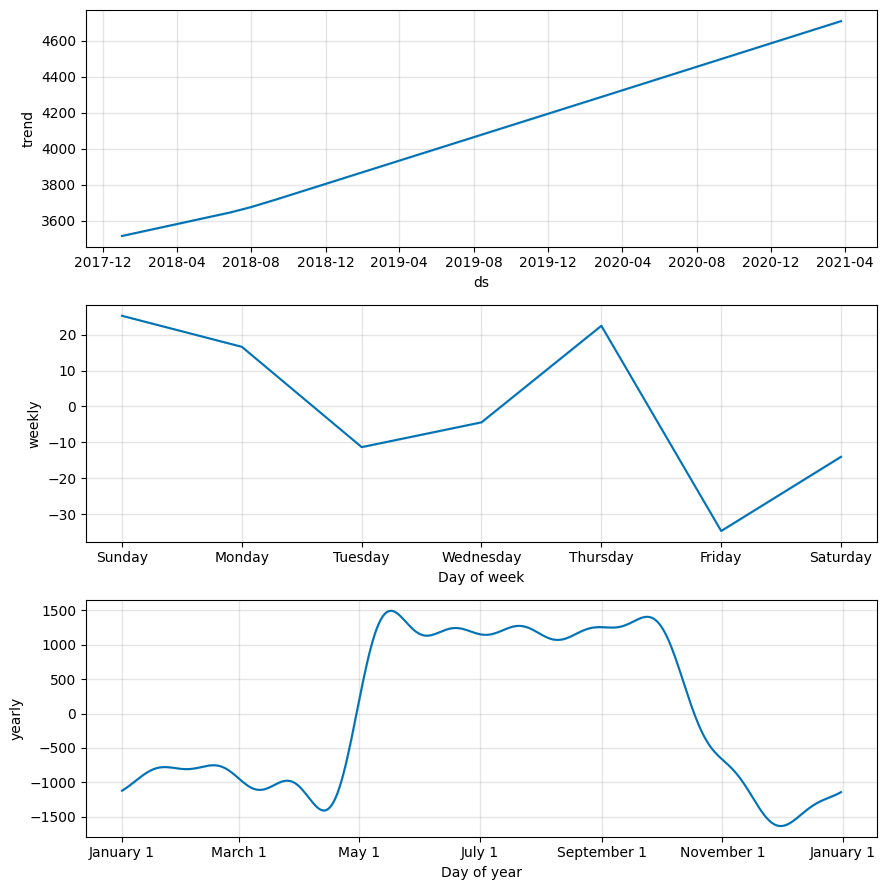

In [99]:
plot1 = reloaded_model.plot_components(reforecast)

## Loop Through All the Store and Vehicle Combinations

In [100]:
import itertools

In [103]:
for product, store in itertools.product(df["Product"].unique(), df["Store"].unique()):
    # print(product, store)
    print(build_model(df, product, store))

17:05:27 - cmdstanpy - INFO - Chain [1] start processing
17:05:27 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for TESLA_MODEL_X and LOS_ANGELES


17:05:28 - cmdstanpy - INFO - Chain [1] start processing
17:05:28 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for TESLA_MODEL_X and SAN_FRANCISCO


17:05:28 - cmdstanpy - INFO - Chain [1] start processing
17:05:28 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for TESLA_MODEL_S and LOS_ANGELES


17:05:29 - cmdstanpy - INFO - Chain [1] start processing
17:05:29 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for TESLA_MODEL_S and SAN_FRANCISCO


In [105]:
# test the saved model by reloading it and making predictions for the future dates

with open("serialized_model_TESLA_MODEL_X_LOS_ANGELES.json", "r") as fin:
    reloaded_model = model_from_json(json.load(fin))

In [106]:
future = reloaded_model.make_future_dataframe(periods = 120, freq = "D")
forecast = reloaded_model.predict(future)
forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1195,2021-04-11,4725.476831,2293.736685,4411.962385,4723.045666,4727.631692,-1365.409285,-1365.409285,-1365.409285,25.219585,25.219585,25.219585,-1390.628869,-1390.628869,-1390.628869,0.0,0.0,0.0,3360.067547
1196,2021-04-12,4726.546764,2252.841459,4348.461168,4724.081338,4728.722545,-1388.330701,-1388.330701,-1388.330701,16.596937,16.596937,16.596937,-1404.927638,-1404.927638,-1404.927638,0.0,0.0,0.0,3338.216063
1197,2021-04-13,4727.616696,2255.942081,4399.790342,4725.118642,4729.811723,-1422.533868,-1422.533868,-1422.533868,-11.287476,-11.287476,-11.287476,-1411.246391,-1411.246391,-1411.246391,0.0,0.0,0.0,3305.082829
1198,2021-04-14,4728.686629,2281.025377,4332.974102,4726.156660,4730.896117,-1412.950729,-1412.950729,-1412.950729,-4.396127,-4.396127,-4.396127,-1408.554601,-1408.554601,-1408.554601,0.0,0.0,0.0,3315.735900
1199,2021-04-15,4729.756561,2356.901519,4473.724830,4727.194472,4731.980510,-1373.506001,-1373.506001,-1373.506001,22.439771,22.439771,22.439771,-1395.945772,-1395.945772,-1395.945772,0.0,0.0,0.0,3356.250560


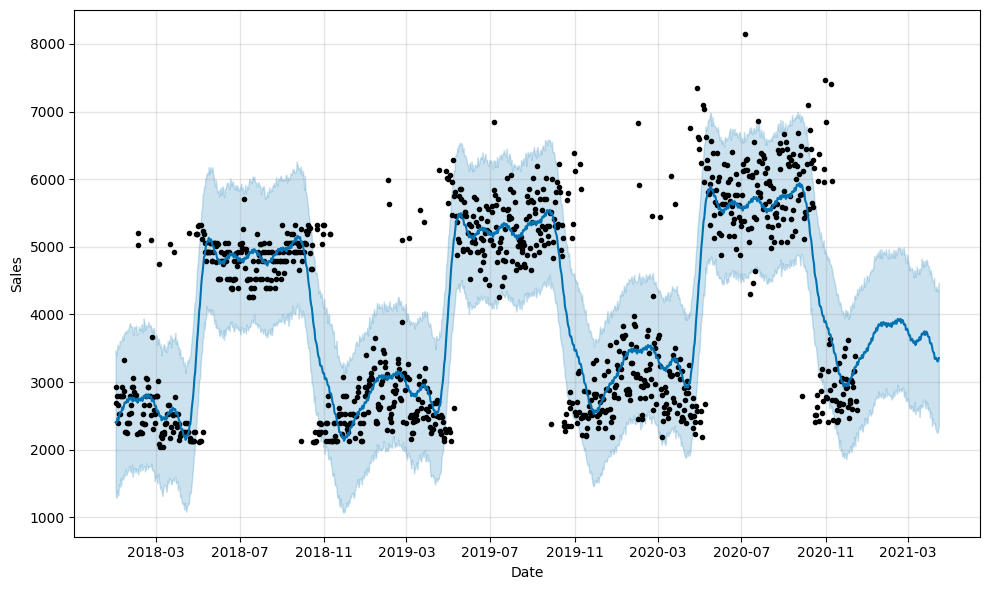

In [108]:
p = reloaded_model.plot(forecast, xlabel = "Date", ylabel = "Sales")

# 8. Build Anvil App

## Create Notebook Uplink

In [109]:
import anvil.server

anvil.server.connect("server_I2DT5LTKOP3W7SMOHE3RRUSM-RMVP75HMRTADTNOJ")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [111]:
import os

# current directory
os.listdir(".")

['.git',
 '.gitignore',
 'dataset.csv',
 'Facebook Prophet.ipynb',
 'LICENSE',
 'README.md',
 'serialized_model.json',
 'serialized_model_TESLA_MODEL_S_LOS_ANGELES.json',
 'serialized_model_TESLA_MODEL_S_SAN_FRANCISCO.json',
 'serialized_model_TESLA_MODEL_X_LOS_ANGELES.json',
 'serialized_model_TESLA_MODEL_X_SAN_FRANCISCO.json']

## Build a Jupyter Callable Function

In [116]:
# Decorator for anvil uplink
@anvil.server.callable
def forecast_future(model, timeframe):
    
    # load the model from the disk
    with open(model, "r") as fin:
        reloaded_model = model_from_json(json.load(fin))
    
    # make predictions for the future
    future = reloaded_model.make_future_dataframe(periods = int(timeframe), freq = "D")
    forecast = reloaded_model.predict(future)
    # filter the columns we return back to the user
    forecast = forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]
    
    # convert df to dictionary
    records_map = forecast.to_dict(orient = 'records')
    # grab the cols to set column names in Data Grid on anvil dasboard
    columns = list(forecast.columns)
    
    return columns, records_map

Test the function


In [117]:
columns, records_map = forecast_future("serialized_model_TESLA_MODEL_S_LOS_ANGELES.json", 100)

In [118]:
columns

['ds', 'yhat_lower', 'yhat', 'yhat_upper']

In [120]:
[{"id" : col, "title" : col, "data_key" : col} for col in columns]

[{'id': 'ds', 'title': 'ds', 'data_key': 'ds'},
 {'id': 'yhat_lower', 'title': 'yhat_lower', 'data_key': 'yhat_lower'},
 {'id': 'yhat', 'title': 'yhat', 'data_key': 'yhat'},
 {'id': 'yhat_upper', 'title': 'yhat_upper', 'data_key': 'yhat_upper'}]

In [119]:
records_map

[{'ds': Timestamp('2018-01-01 00:00:00'),
  'yhat_lower': 1560.3240658930386,
  'yhat': 2667.594353473436,
  'yhat_upper': 3753.8080511283574},
 {'ds': Timestamp('2018-01-02 00:00:00'),
  'yhat_lower': 1535.5077607636142,
  'yhat': 2657.159582617522,
  'yhat_upper': 3719.20707871881},
 {'ds': Timestamp('2018-01-03 00:00:00'),
  'yhat_lower': 1516.7460744904467,
  'yhat': 2686.0873660791367,
  'yhat_upper': 3927.5186893632094},
 {'ds': Timestamp('2018-01-04 00:00:00'),
  'yhat_lower': 1572.6569617144742,
  'yhat': 2738.1266999287977,
  'yhat_upper': 3868.893023608161},
 {'ds': Timestamp('2018-01-05 00:00:00'),
  'yhat_lower': 1424.521097639315,
  'yhat': 2698.914834026719,
  'yhat_upper': 3809.210905637265},
 {'ds': Timestamp('2018-01-06 00:00:00'),
  'yhat_lower': 1534.4602228901356,
  'yhat': 2746.918903793905,
  'yhat_upper': 3874.8622223458324},
 {'ds': Timestamp('2018-01-07 00:00:00'),
  'yhat_lower': 1742.5150440242141,
  'yhat': 2814.5266095615316,
  'yhat_upper': 3984.0416008132

## Add Client Side Scripts